# Use Kasumi (MISTy with sliding windows) on MIBI data

## Imports

In [1]:
library(mistyR)
library(kasumi)
library(tidyverse)
library(future)
library(proxy)
library(withr)
library(igraph)

mistyR is able to run computationally intensive functions
  in parallel. Please consider specifying a future::plan(). For example by running
  future::plan(future::multisession) before calling mistyR functions.

Kasumi is able to run computationally intensive functions
  in parallel. Please consider specifying a future::plan(). For example by running
  future::plan(future::multisession) before calling Kasumi functions.

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────

## Helper functions

In [2]:
leiden_onsim <- function(representation, minsim = 0.8, resolution = 0.8, measure = "cosine") {
  sim <- simil(representation, measure)

  sim[sim < minsim] <- 0
  with_seed(
    1,
    groups <-
      graph.adjacency(sim %>% as.matrix(), mode = "undirected", weighted = TRUE) %>%
      cluster_leiden(resolution_parameter = resolution, n_iterations = -1)
  )

  return(groups$membership)
}

In [3]:
sm_repr <- function(misty.results, cuts, res, cutoff = 0, trim = 1) {
  # trimming matters
  sig <- extract_signature(misty.results, type = "i", intersect.targets = FALSE, trim = trim)
  sig[is.na(sig)] <- floor(min(sig %>% select(-sample), na.rm = TRUE))
  sig <- sig %>% mutate(across(!sample, ~ ifelse(.x <= cutoff, 0, .x)))

  keep <- which(sig %>% select(-sample, -contains("intra_")) %>% rowSums() != 0)

  samps <- sig %>%
    dplyr::slice(keep) %>%
    select(sample) %>%
    mutate(
      id = str_extract(sample, ".*/") %>% str_remove("/"), # Sample names should not contain "/"
      box = str_extract(sample, "/[0-9].*$") %>% str_remove("/")
    ) %>%
    rowwise(id) %>%
    summarize(rebox = box %>%
      str_split("_", simplify = T) %>%
      as.numeric() %>% list(), .groups = "drop") %>%
    rowwise(id) %>%
    summarize(
      xcenter = (rebox[3] + rebox[1]) / 2,
      ycenter = (rebox[4] + rebox[2]) / 2, .groups = "drop"
    )

  # the filtering here also matters
  clean <- sig %>%
    select(-sample, -contains("_.novar")) %>%
    dplyr::slice(keep) %>%
    select(where(~ sum(.) != 0))


  clusters <- leiden_onsim(clean, cuts, res)

  suppressMessages(
    sm.repr <- map(clusters, ~ .x == seq(length(unique(clusters)))) %>% reduce(rbind) %>%
      as_tibble(.name_repair = "unique") %>% cbind(samps) %>% group_by(id) %>%
      rename(x = xcenter, y = ycenter) %>%
      group_split()
  )


  return(sm.repr)
}

In [4]:
sm_labels <- function(misty.results, cuts, res, cutoff = 0, trim = 1, freq = TRUE) {
  sm.repr <- sm_repr(misty.results, cuts, res, cutoff, trim)

  if (!freq) {
    return(sm.repr)
  }

  repr.ids <- sm.repr %>% map_chr(~ .x$id[1])

  # technically we can also use pa_repr instead of freq_repr or combine both
  freq.sm <- sm.repr %>%
    map_dfr(~ .x %>%
      select(-c(id, x, y)) %>%
      freq_repr()) %>%
    select(where(~ (sd(.) > 1e-3) & (sum(. > 0) >= min(length(repr.ids), max(5, 0.1 * length(.)))))) %>%
    add_column(id = repr.ids, .before = 1)

  return(freq.sm)
}

In [5]:
freq_repr <- function(labels) {
  colSums(labels) / sum(labels)
}

## Load

In [10]:
# Load your transformed cell table
cells = read_csv("../../data/cell_table_with_types_stage.csv")
head(cells)

New names:
• `` -> `...1`
Rows: 579011 Columns: 70
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (31): fov, annotation_t, annotation_scyan, consensus, annotation_consens...
dbl (37): ...1, CA9, nuclei, CD98, CytC, MSH2, MCT1, PDL1, PD1, ASCT2, LDH, ...
lgl  (2): Grade raw, pM group

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1 CA9        nuclei     CD98        CytC       MSH2       MCT1        
1 0    0.02128943 0.04614832 0.006392956 0.01571343 0.02473370 0.0001934555
2 1    0.01457781 0.03423819 0.008830998 0.10651270 0.06347377 0.0027742222
3 2    0.11329879 0.06419776 0.034138213 0.01142891 0.06656348 0.0015064266
4 3    0.12827739 0.09715288 0.040913454 0.03036816 0.01601639 0.0052802216
5 4    0.10768224 0.05414692 0.070130227 0.09855133 0.08103716 0.0209243360
6 5    0.10965646 0.01982199 0.026331486 0.06694059 0.02464267 0.0497367896
  PDL1        PD1         ASCT2      ⋯ RAS Mutation RED RAS Mutation RED 2
1 0.009022579 0.004549611 0.04586374 ⋯ NA               NA                
2 0.004172783 0.000000000 0.02873399 ⋯ NA               NA                
3 0.009497505 0.000000000 0.02825994 ⋯ NA               NA                
4 0.022267382 0.028413114 0.03409141 ⋯ NA               NA                
5 0.004453675 0.022994452 0.11757625 ⋯ NA               NA                
6 0.001608107 0.027431549 0.19049839 ⋯ NA               NA                
  BRAF Mutation RED HER2 Amplifikation Age Sex MIBI     Tumor Size Group
1 NA                NA                 88  w   acquired NA              
2 NA                NA                 88  w   acquired NA              
3 NA                NA                 88  w   acquired NA              
4 NA                NA                 88  w   acquired NA              
5 NA                NA                 88  w   acquired NA              
6 NA                NA                 88  w   acquired NA              
  Age Group   Stage
1 70 and Over pT3  
2 70 and Over pT3  
3 70 and Over pT3  
4 70 and Over pT3  
5 70 and Over pT3  
6 70 and Over pT3

In [11]:
# Exclude low epithelial abundance samples and SCT samples (start with "E1" or "E2")

# See StageXGB.ipynb
excluded_fovs = c('A2n','A3r','A4i','A5c','A7c','A7m','A8f','A9k','A9p','B1q','B2l',
                  'B2n','B3o','B4a','B4n','B5h','B5i','B5p','B6l','B7g','B7k','B7q',
                  'B8c','B9r','C2e','C9a','C9d','C9e','C9i','D1c','D1g','D2c','D3m',
                  'D4e','D6e','D6i','D7b','D8m','D9g','D9l')

cells <- cells %>% 
    filter(!(fov %in% excluded_fovs)) %>%
    filter(!grepl("^E[1-2]", fov))

## Format for Kasumi

In [12]:
ws <- 256 # Window size, similar to other MIBI datasets, split FOV in 4x4
paraview_l <- 120 # Distance in pixels up to which an effect will be considered in the paraview
juxtaview_l <- 40 # Distance in pixels up to which a cell is considered a direct neighbor
panel = c('CA9', 'CD98', 'CytC', 'MCT1', 'ASCT2', 'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'ARG1', 'CPT1A', 'Ki67')  # Markers to be used for the analysis
outputfile = "kasumi_colorectal_metab_256.sqm"

In [13]:
# Expected data is a list of tibbles with each one containing the marker expressions (columns) per cell (rows) for a fov
markers <- cells %>% group_by(fov) %>% select(all_of(panel)) %>% group_split(.keep = FALSE)

Adding missing grouping variables: `fov`


In [14]:
# Coordinates of each cell
positions <- cells %>% group_by(fov) %>% 
    mutate(x = `centroid-0`, y = `centroid-1`) %>%
    select(fov, x, y) %>%
    group_split(.keep = FALSE)

## Run Kasumi

In [15]:
# Keep track of the order of the FOVs in the markers table / kasumi output
deduplicated_cells <- cells %>%
  group_by(fov) %>%
  dplyr::slice(1) %>%
  ungroup()

In [ ]:
# Apply the function to each marker
outputs <- seq_along(markers) %>% walk(
# outputs <- seq(from = 201, to = length(markers)) %>% walk(
    function(i) {
    print(i)
    misty.views <- create_initial_view(markers[[i]]) %>%
        add_paraview(positions[[i]], paraview_l,
            family = "gaussian", cached = TRUE,
            prefix = "p.", zoi = juxtaview_l,
        ) %>%
        add_juxtaview(positions[[i]], juxtaview_l,
            prefix = "l."
        )

    folders <- run_kasumi(misty.views, positions[[i]], ws,
        sample.id = deduplicated_cells$fov[i],
        results.db = outputfile,
        bypass.intra = FALSE,
        cv.strict = TRUE,
        minu = 20,
        overlap = 0,
        sqlite_timeout = 100
    )})

# # Copy the output file to roll back to later it if necessary
# file.copy(outputfile, paste0(outputfile, ".200.bak"))

[1] 1



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki

[1] 2



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Wa

[1] 3



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 4



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”


[1] 5



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”


[1] 6



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Wa

[1] 7



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 8



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG

[1] 9



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”


[1] 10



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Wa

[1] 11



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A

[1] 12



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98

[1] 13



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 14



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 15



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A

[1] 16



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2

[1] 17



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 18



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 19



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Wa

[1] 20



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 21



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”


[1] 22



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 23



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”


[1] 24



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”


[1] 25



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT

[1] 26



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1

[1] 27



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 28



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target 

[1] 29



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”


[1] 30



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
W

[1] 31



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”

[1] 32



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 33



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”

[1] 34



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 35



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 36



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”


[1] 37



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC

[1] 38



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
W

[1] 39



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”


[1] 40



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2

[1] 41



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”

[1] 42



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”


[1] 43



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 44



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target 

[1] 45



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 46



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki

[1] 47



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 48



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warn

[1] 49



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 50



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
W

[1] 51



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”

[1] 52



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
W

[1] 53



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”

[1] 54



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1

[1] 55



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 56



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 57



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 58



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”

[1] 59



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1

[1] 60



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”


[1] 61



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki

[1] 62



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target 

[1] 63



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
W

[1] 64



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG

[1] 65



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”


[1] 66



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
W

[1] 67



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target AR

[1] 68



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target

[1] 69



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Wa

[1] 70



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
W

[1] 71



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 72



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 73



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Wa

[1] 74



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9

[1] 75



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MC

[1] 76



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 77



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”


[1] 78



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”

[1] 79



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 80



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 81



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT

[1] 82



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
War

[1] 83



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target G

[1] 84



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1

[1] 85



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 86



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”


[1] 87



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD9

[1] 88



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”


[1] 89



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”


[1] 90



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
War

[1] 91



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 92



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”

[1] 93



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Cyt

[1] 94



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
W

[1] 95



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Cyt

[1] 96



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 97



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 98



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC

[1] 99



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
W

[1] 100



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target C

[1] 101



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
W

[1] 102



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
W

[1] 103



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD

[1] 104



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GL

[1] 105



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”

[1] 106



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”


[1] 107



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target AR

[1] 108



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”

[1] 109



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 110



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 111



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
W

[1] 112



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 113



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
W

[1] 114



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1

[1] 115



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Wa

[1] 116



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”

[1] 117



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 118



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1

[1] 119



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA

[1] 120



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1

[1] 121



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT

[1] 122



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Cyt

[1] 123



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Wa

[1] 124



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
W

[1] 125



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 126



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”


[1] 127



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 128



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 129



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”

[1] 130



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”


[1] 131



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA

[1] 132



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”

[1] 133



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS

[1] 134



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target

[1] 135



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”


[1] 136



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 137



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”

[1] 138



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
W

[1] 139



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1

[1] 140



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD9

[1] 141



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”

[1] 142



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”

[1] 143



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 144



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1

[1] 145



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 146



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”


[1] 147



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 148



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 149



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target C

[1] 150



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 151



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
W

[1] 152



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”

[1] 153



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 154



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”


[1] 155



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 156



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
W

[1] 157



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A

[1] 158



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”


[1] 159



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9

[1] 160



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target 

[1] 161



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 162



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 163



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 164



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LD

[1] 165



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target AS

[1] 166



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”

[1] 167



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 168



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC

[1] 169



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 170



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 171



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target L

[1] 172



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT

[1] 173



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Wa

[1] 174



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Wa

[1] 175



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target G

[1] 176



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GL

[1] 177



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Wa

[1] 178



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Wa

[1] 179



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 180



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”

[1] 181



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Cyt

[1] 182



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Wa

[1] 183



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”


[1] 184



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”

[1] 185



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
W

[1] 186



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”


[1] 187



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 188



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”

[1] 189



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98

[1] 190



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 191



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG

[1] 192



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 193



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”

[1] 194



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”


[1] 195



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”


[1] 196



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 197



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 198



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
W

[1] 199



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A

[1] 200



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MC

[1] 201



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LD

[1] 202



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”

[1] 203



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”


[1] 204



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”


[1] 205



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 206



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9

[1] 207



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA

[1] 208



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 209



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warn

[1] 210



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
W

[1] 211



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Wa

[1] 212



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1

[1] 213



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT

[1] 214



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 215



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target 

[1] 216



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9

[1] 217



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 218



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”

[1] 219



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
W

[1] 220



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Wa

[1] 221



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target P

[1] 222



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 223



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 224



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”

[1] 225



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
W

[1] 226



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
W

[1] 227



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Wa

[1] 228



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 229



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 230



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1

[1] 231



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 232



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 233



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC

[1] 234



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 235



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”


[1] 236



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”

[1] 237



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target A

[1] 238



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”

[1] 239



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 240



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”

[1] 241



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
W

[1] 242



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT

[1] 243



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GL

[1] 244



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”

[1] 245



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”

[1] 246



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”


[1] 247



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98

[1] 248



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Wa

[1] 249



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG

[1] 250



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG

[1] 251



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM

[1] 252



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
W

[1] 253



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
W

[1] 254



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”


[1] 255



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 256



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT

[1] 257



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”


[1] 258



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 259



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 260



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Wa

[1] 261



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC

[1] 262



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”


[1] 263



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 264



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”


[1] 265



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1

[1] 266



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 267



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”


[1] 268



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”

[1] 269



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”

[1] 270



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 271



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”

[1] 272



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 273



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 274



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”

[1] 275



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
W

[1] 276



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA

[1] 277



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”

[1] 278



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
W

[1] 279



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 280



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target AR

[1] 281



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
W

[1] 282



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 283



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 284



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS

[1] 285



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 286



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target A

[1] 287



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98

[1] 288



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”


[1] 289



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT

[1] 290



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 291



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
W

[1] 292



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 293



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 294



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 295



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 296



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9

[1] 297



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
W

[1] 298



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
W

[1] 299



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT

[1] 300



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”


[1] 301



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 302



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT

[1] 303



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target AR

[1] 304



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Wa

[1] 305



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target 

[1] 306



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1

[1] 307



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 308



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 309



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 310



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
W

[1] 311



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”

[1] 312



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 313



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”


[1] 314



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MC

[1] 315



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA

[1] 316



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH

[1] 317



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target M

[1] 318



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”

[1] 319



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 320



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target K

[1] 321



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”


[1] 322



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 323



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2

[1] 324



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target AS

[1] 325



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”

[1] 326



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT

[1] 327



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki

[1] 328



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
War

[1] 329



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”


[1] 330



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 331



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Wa

[1] 332



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2

[1] 333



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM

[1] 334



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT

[1] 335



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”


[1] 336



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Wa

[1] 337



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1

[1] 338



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS

[1] 339



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
W

[1] 340



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”

[1] 341



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67

[1] 342



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”


[1] 343



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2

[1] 344



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 345



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”


[1] 346



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1A”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
W

[1] 347



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 348



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Wa

[1] 349



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH

[1] 350



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9

[1] 351



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 352



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”

[1] 353



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1

[1] 354



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”

[1] 355



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 356



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 357



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ATP5A”

[1] 358



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CA9”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CPT1

[1] 359



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target MCT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ASCT2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target LDH”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki6

[1] 360



Computing triangulation


Generating juxtaview


Sliding

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CytC”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PKM2”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target ARG1”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target Ki67”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target CD98”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GS”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target GLUT1

[1] 361



Computing triangulation


Generating juxtaview


Sliding



If the process is interrupted, you can resume from the last checkpoint after cleanup:
```Python
# Remove corrupted output file and replace it with back up
file.remove(outputfile)
file.copy(paste0(outputfile, ".100.bak"), outputfile)
```

In [19]:
plan(multisession, workers = 30) # Bring up when no other users are active

In [20]:
misty.results <- collect_results(outputfile)








Aggregating



In [21]:
write_rds(misty.results, paste0(str_remove(outputfile, ".sqm"), ".rds"), "gz")

In [33]:
misty.results <- read_rds(paste0(str_remove(outputfile, ".sqm"), ".rds"))

In [34]:
# Get unique FOVs (first part of samples)
fov.results <- misty.results$contributions$sample %>% 
    strsplit("/") %>%
    map_chr(~ .x[1]) %>%
    unique()
# Are all samples present?

print(fov.results %>% length())
print(fov.results)

[1] 423
  [1] "A1a" "A1c" "A1d" "A1e" "A1f" "A1h" "A1i" "A1k" "A1l" "A1m" "A1n" "A1o"
 [13] "A1p" "A1q" "A1r" "A2a" "A2b" "A2c" "A2d" "A2e" "A2g" "A2h" "A2i" "A2k"
 [25] "A2l" "A2m" "A2o" "A2p" "A2q" "A2r" "A3a" "A3b" "A3c" "A3d" "A3e" "A3f"
 [37] "A3g" "A3h" "A3i" "A3l" "A3m" "A3n" "A3o" "A3p" "A3q" "A4a" "A4b" "A4c"
 [49] "A4d" "A4e" "A4f" "A4h" "A4k" "A4l" "A4m" "A4n" "A4o" "A4p" "A4q" "A4r"
 [61] "A5a" "A5b" "A5d" "A5e" "A5f" "A5g" "A5i" "A5k" "A5l" "A5m" "A5n" "A5o"
 [73] "A5p" "A5q" "A6b" "A6c" "A6d" "A6e" "A6g" "A6h" "A6i" "A6k" "A6l" "A6m"
 [85] "A6n" "A6o" "A6p" "A6q" "A6r" "A7a" "A7b" "A7d" "A7f" "A7g" "A7h" "A7k"
 [97] "A7l" "A7n" "A7o" "A7p" "A7q" "A7r" "A8a" "A8b" "A8c" "A8d" "A8e" "A8g"
[109] "A8h" "A8i" "A8l" "A8m" "A8n" "A8o" "A8p" "A8q" "A8r" "A9a" "A9b" "A9c"
[121] "A9d" "A9e" "A9f" "A9g" "A9h" "A9i" "A9l" "A9m" "A9n" "A9o" "A9q" "A9r"
[133] "B1a" "B1b" "B1c" "B1d" "B1e" "B1f" "B1g" "B1h" "B1i" "B1k" "B1n" "B1o"
[145] "B1p" "B2a" "B2b" "B2c" "B2e" "B2f" "B2g" "B2h" "B

## Visualize model performance across samples

In [25]:
markers[[1]]

CA9         CD98        CytC         MCT1         ASCT2       LDH         
1    0.02128943  0.006392956 0.015713432  0.0001934555 0.045863737 0.013713424 
2    0.01457781  0.008830998 0.106512703  0.0027742222 0.028733991 0.002855385 
3    0.11329879  0.034138213 0.011428911  0.0015064266 0.028259936 0.013808767 
4    0.12827739  0.040913454 0.030368158  0.0052802216 0.034091409 0.032230635 
5    0.10768224  0.070130227 0.098551333  0.0209243360 0.117576254 0.035626791 
6    0.10965646  0.026331486 0.066940587  0.0497367896 0.190498388 0.011646049 
7    0.07710017  0.019551024 0.035456576  0.0058438839 0.079408106 0.013822320 
8    0.03903885  0.072703199 0.019317055  0.0021476059 0.235652963 0.001822564 
9    0.04411054  0.022736779 0.030429127  0.0148444776 0.170603224 0.001785875 
10   0.19928974  0.036936626 0.017447091  0.0011276189 0.087251418 0.023726948 
11   0.01735548  0.153820802 0.001627744  0.0087436779 0.119280831 0.007814243 
12   0.05969942  0.103052759 0.026807459  0.0179406617 0.055684673 0.033380784 
13   0.17912831  0.218307443 0.073898564  0.0165674091 0.152033300 0.130695621 
14   0.04357613  0.065106088 0.005284411  0.0119918595 0.049204565 0.048060263 
15   0.22999597  0.113669059 0.049414121  0.0005820007 0.003613312 0.005702927 
16   0.00779755  0.063042005 0.001910450  0.0012866453 0.014205802 0.003437055 
17   0.02661014  0.112638172 0.009619783  0.0033224616 0.060501565 0.018346742 
18   0.02552434  0.045310453 0.105964413  0.0027688045 0.045349963 0.010191537 
19   0.03616843  0.052748048 0.040495556  0.0046877493 0.125901112 0.009177445 
20   0.08723542  0.173290611 0.002600524  0.0051109803 0.188606346 0.130002492 
21   0.06037217  0.253024175 0.008403570  0.0234598967 0.365010601 0.024647594 
22   0.09454495  0.104157203 0.020908617  0.0568024611 0.287037046 0.014422797 
23   0.04619349  0.035479910 0.067359316  0.0135066383 0.154798876 0.044637314 
24   0.11658797  0.036449283 0.019729361  0.0340650672 0.207570573 0.050832279 
25   0.12709603  0.016175210 0.074440249  0.0212443085 0.173729307 0.031036710 
26   0.11502727  0.045057337 0.101196542  0.0313533010 0.202205110 0.039017930 
27   0.07453811  0.044464122 0.073538316  0.0274190284 0.193009649 0.073163080 
28   0.09648506  0.037867395 0.137598724  0.0131594842 0.183068274 0.024275881 
29   0.07638042  0.001085383 0.139769972  0.0002244065 0.111149036 0.028989631 
30   0.12883886  0.028066238 0.105241524  0.0000000000 0.186053415 0.000000000 
⋮    ⋮           ⋮           ⋮            ⋮            ⋮           ⋮           
1519 0.002744341 0.016266085 0.0000000000 4.071917e-03 0.005894528 0.0064697166
1520 0.027800443 0.106408308 0.0133722548 3.638419e-04 0.180351107 0.0146479672
1521 0.027586195 0.167584686 0.0010650769 4.039868e-03 0.134755428 0.0179489717
1522 0.010239676 0.134773846 0.0051115375 5.867316e-04 0.025750339 0.0064348815
1523 0.045042879 0.067805956 0.0063054269 4.208399e-03 0.133033036 0.0173115179
1524 0.033770301 0.012722595 0.0693915162 3.094881e-03 0.129107172 0.0046033686
1525 0.028216696 0.017312543 0.0716101715 3.679318e-05 0.109041371 0.0097480820
1526 0.029057413 0.076322860 0.0291046968 5.140865e-03 0.129605876 0.0317147384
1527 0.022796640 0.040222626 0.0037998600 7.890236e-04 0.012773063 0.0184569990
1528 0.068910755 0.040878201 0.0154144157 2.010331e-02 0.085425201 0.0461174202
1529 0.048047998 0.008151735 0.0151868247 1.603618e-04 0.094254678 0.0190340835
1530 0.014591613 0.004438169 0.1897656838 7.032310e-06 0.018195275 0.0199754987
1531 0.131882082 0.030805375 0.0004671947 4.078848e-02 0.021897296 0.0856051688
1532 0.051637624 0.044868249 0.0191623879 2.050063e-02 0.125243706 0.0315909651
1533 0.045516768 0.018159252 0.0147313717 3.290366e-04 0.085842161 0.0036263007
1534 0.043700919 0.074393640 0.0163084027 2.765890e-03 0.291126662 0.0047337094
1535 0.030222556 0.002016404 0.0152546977 6.735558e-04 0.039267263 0.0019104410
1536 0.025174606 0.022848379 0.0690497316 8.292469e-04 0.105790141 0.0111094594
1537 

In [35]:
table(misty.results$contributions$target)


 ARG1 ASCT2 ATP5A   CA9  CD98 CPT1A    CS  CytC   GLS GLUT1    GS  Ki67   LDH 
51672 51672 51664 51672 51664 51672 51672 51672 51672 51672 51672 51672 51664 
 MCT1  PKM2 
51624 51672 

In [36]:
c <- misty.results$contributions
c %>% head()
c[c$value %>% is.na(), "target"] %>% table

target sample                    view         value      
1 CA9    A1a/3.4_4.33_259.4_260.33 intercept    -0.02702815
2 CA9    A1a/3.4_4.33_259.4_260.33 intraview     1.11247264
3 CA9    A1a/3.4_4.33_259.4_260.33 paraview.120  0.33880481
4 CA9    A1a/3.4_4.33_259.4_260.33 juxtaview.40 -0.01364529
5 CA9    A1a/3.4_4.33_259.4_260.33 p.intercept           NA
6 CA9    A1a/3.4_4.33_259.4_260.33 p.intraview   0.00000000

target
 ARG1 ASCT2 ATP5A   CA9  CD98 CPT1A    CS  CytC   GLS GLUT1    GS  Ki67   LDH 
 6459  6459  6458  6459  6458  6459  6459  6459  6459  6459  6459  6459  6458 
 MCT1  PKM2 
 6453  6459 

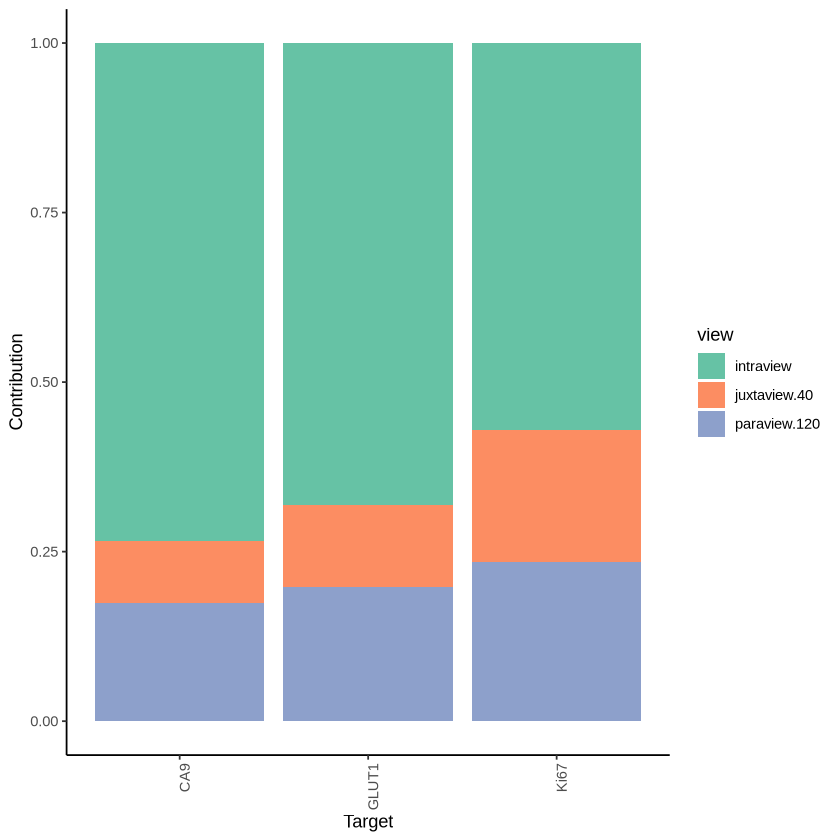

In [80]:
plot_view_contributions(misty.results, trim = 1)

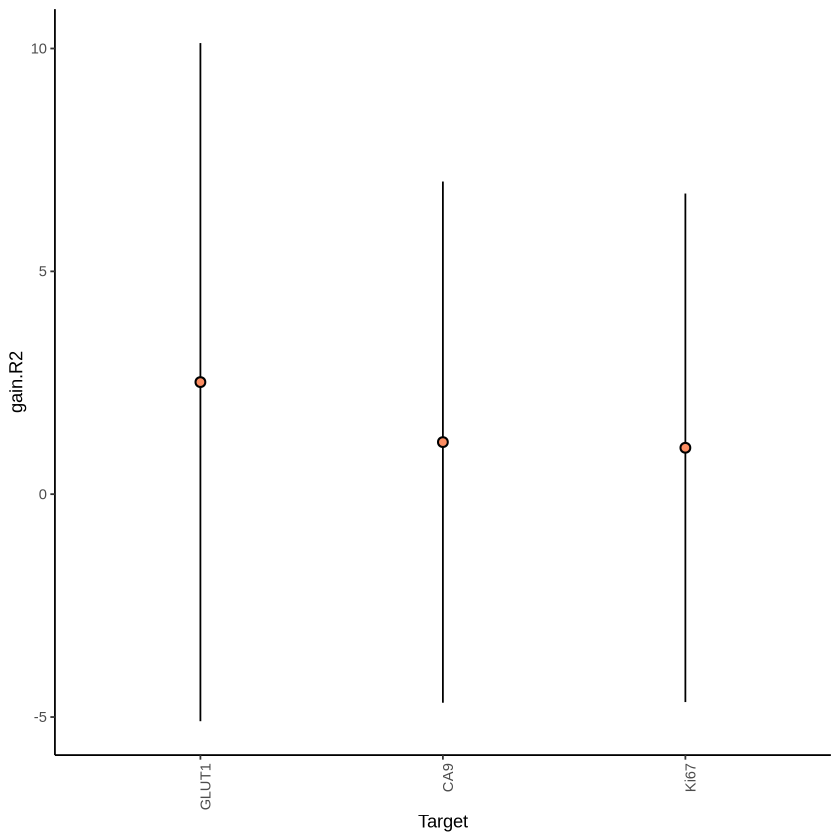

In [81]:
plot_improvement_stats(misty.results, trim = 1)

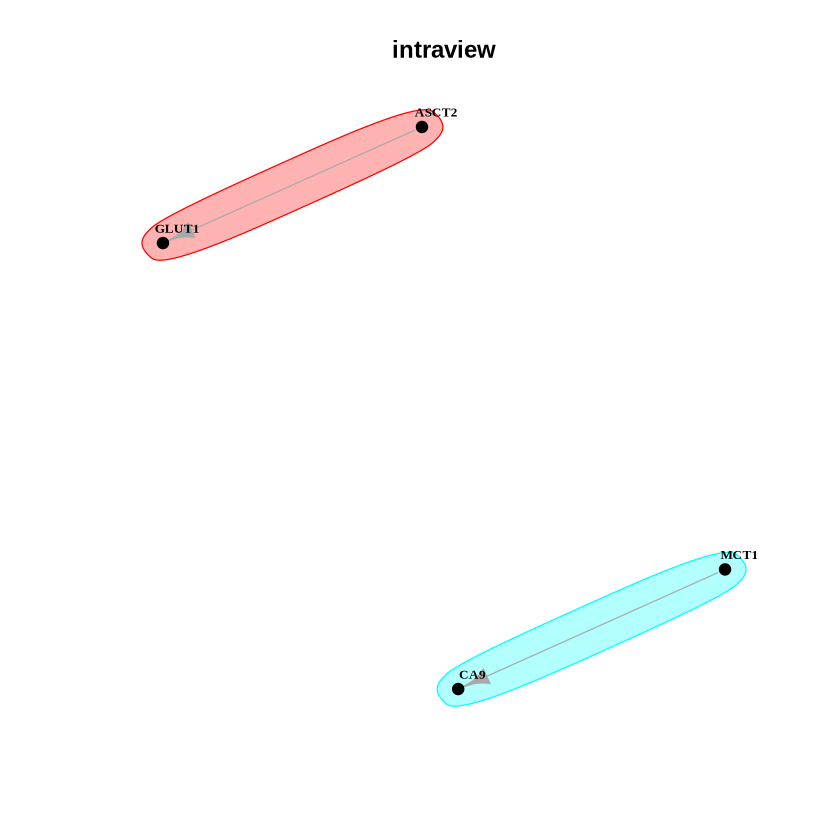

In [82]:
plot_interaction_communities(misty.results, view = "intraview", trim = 1)

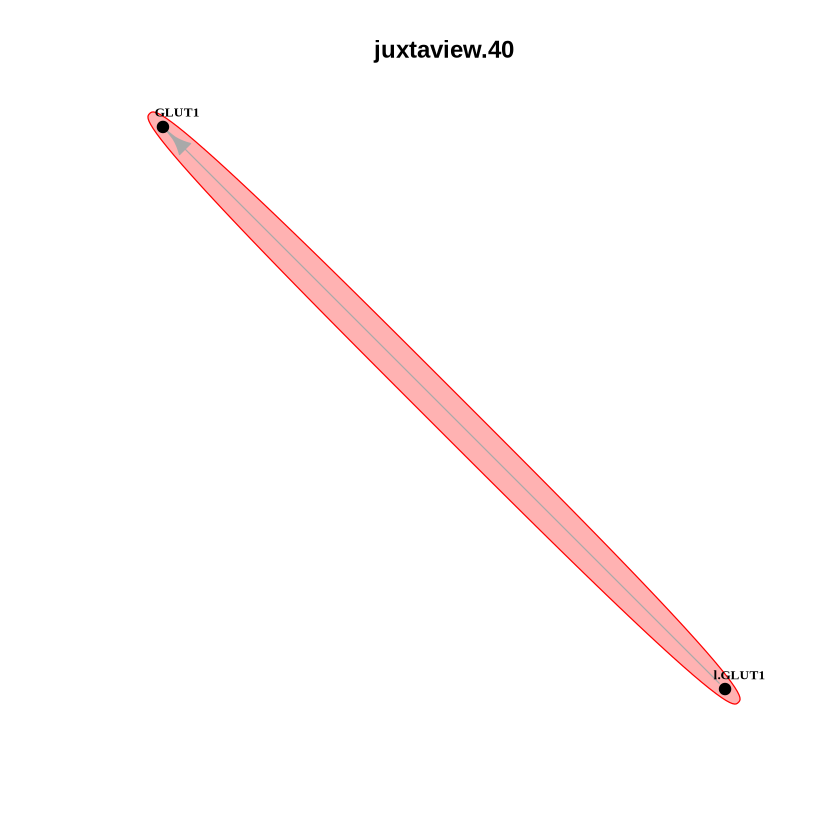

In [83]:
plot_interaction_communities(misty.results, view = "juxtaview.40", trim = 1)

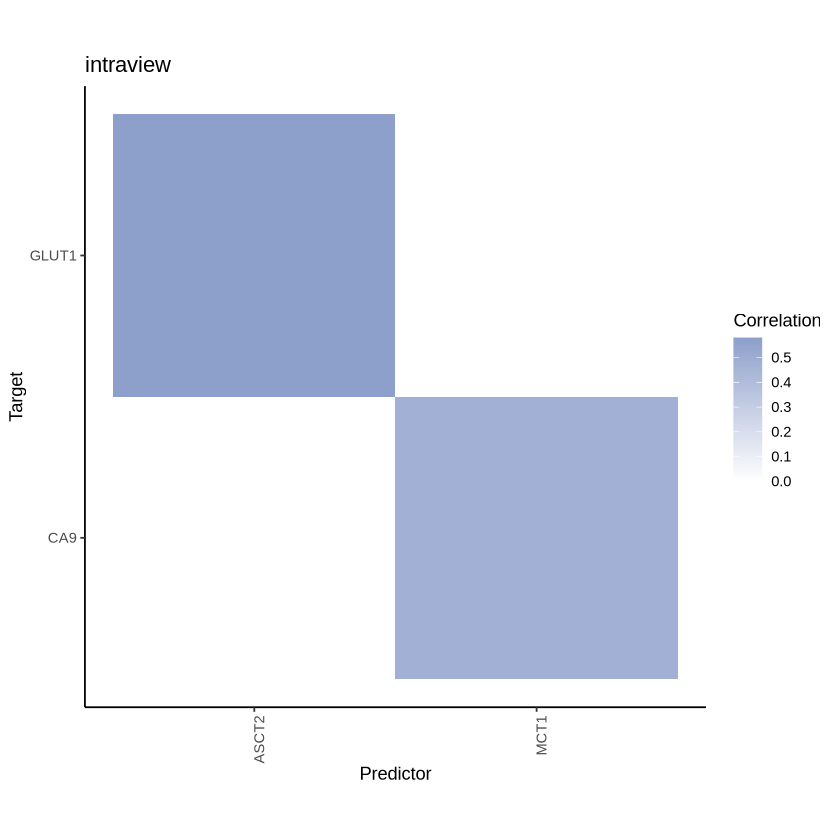

In [84]:
plot_interaction_heatmap(misty.results, view = "intraview", clean = TRUE, correlation = TRUE, trim = 1)

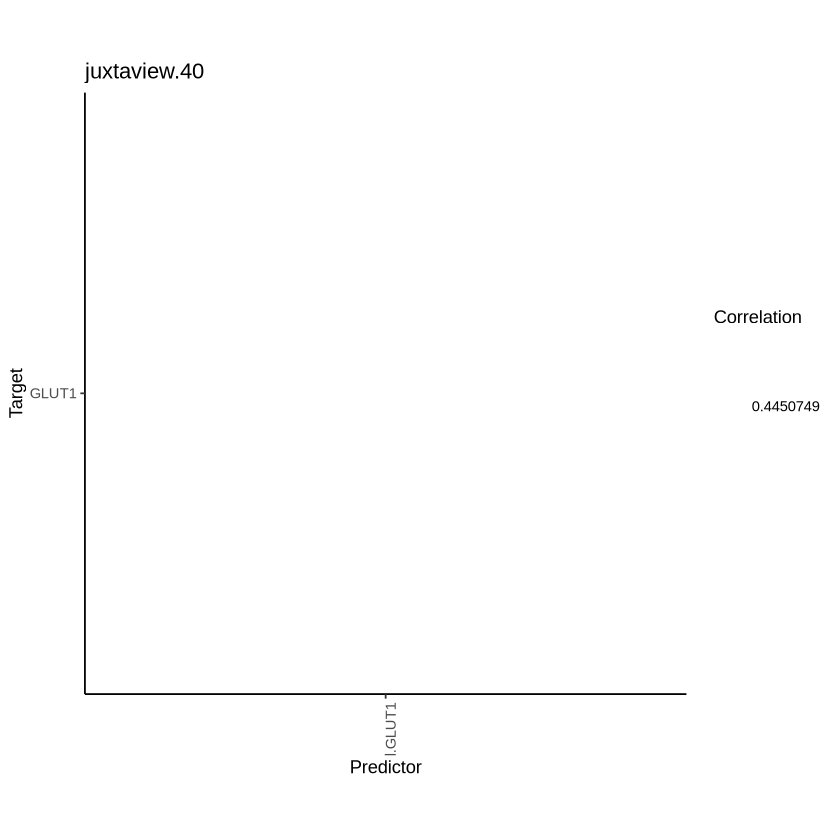

In [85]:
plot_interaction_heatmap(misty.results, view = "juxtaview.40", clean = TRUE, correlation = TRUE, trim = 1)

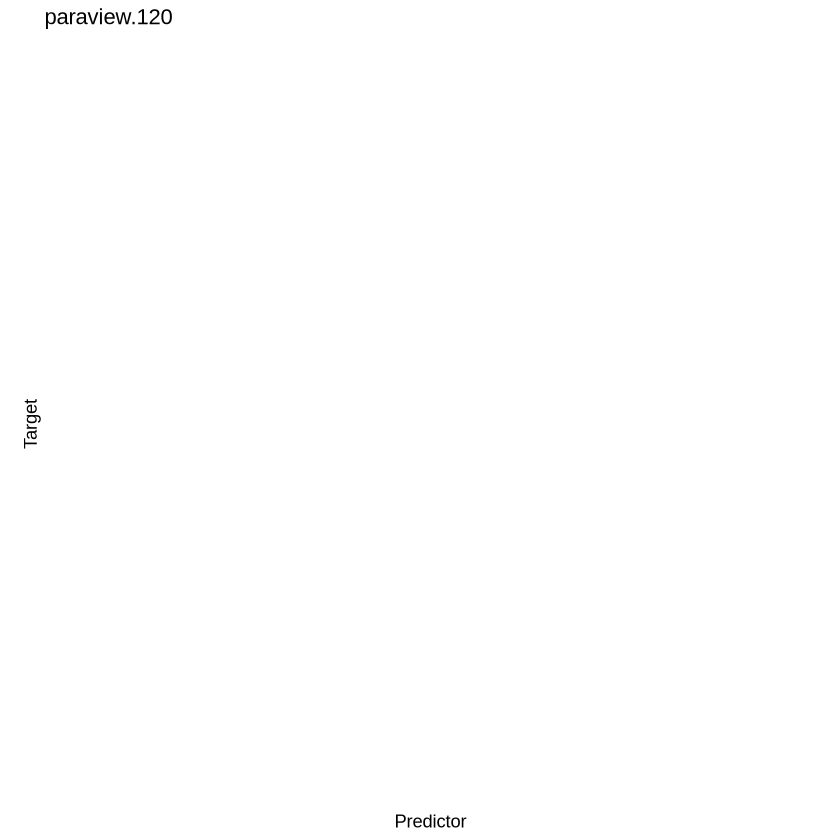

In [86]:
plot_interaction_heatmap(misty.results, view = "paraview.120", clean = TRUE, correlation = TRUE, trim = 1)

## Get and export window clusters

Export overall association significances

In [78]:
fov_features <- extract_signature(misty.results, type = "i", intersect.targets = FALSE, trim = 1)
print(dim(fov_features))
fov_features[is.na(fov_features)] <- floor(min(fov_features %>% select(-sample), na.rm = TRUE))
fov_features <- fov_features %>% mutate(across(!sample, ~ ifelse(.x <= 0.9, 0, .x)))
# Drop columns with all zeros
keep <- names(which(fov_features %>% select(-sample, -contains("intraview_")) %>% colSums() > 0))
fov_features <- fov_features %>%
    select(sample, all_of(keep)) %>%
    mutate(
        fov = str_extract(sample, ".*/") %>% str_remove("/")
    ) %>% 
    group_by(fov) %>%
    summarize(across(!sample, ~ median(.x, na.rm = TRUE)), .groups = "drop")
keep <- names(which(fov_features %>% select(-fov) %>% colSums() > 0))
fov_features %>%
    select(fov, all_of(keep)) %>%
    write_csv("../../data/kasumi_metab_features.csv")

[1] 6459  136


Generate clusters at different resolutions.

In [62]:
# Make sur the output directory exists
dir.create(paste0(str_remove(outputfile, ".sqm"), "_clusters"), showWarnings = FALSE)
# Set seed
set.seed(1)

i = 0
while (i < 50) { # Number of random cuts and resolutions to simulate
    rand_cuts = round(runif(1)/2, 3)
    rand_res = round(runif(1)/2, 3)
    rand_labels = sm_labels(misty.results, cuts = rand_cuts, res = rand_res)
    if (ncol(rand_labels) >= 3) { # At least 2 conserved clusters
        write_csv(rand_labels, paste0(str_remove(outputfile, ".sqm"), 
                                      "_clusters/cuts_", 
                                      rand_cuts, 
                                      "_res_", 
                                      rand_res, 
                                      ".csv"))
        i = i + 1
    }
}

We take the clusters that led to the best modelling of disease stages, if any (see *StageXGB.ipynb*).

In [ ]:
sm.repr <- sm_labels(misty.results, cuts = 0.3, res = 0.3) 
sm.repr.ext <- sm_labels(misty.results, cuts = 0.3, res = 0.3, freq=FALSE)
# Current most interesting: 0.3/0.3 and 0.4/0.4 (0.25 is too little and 0.5 too much)

## Visualize clusters in each FOV

In [132]:
library(extraDistr)
library(ggrepel)
library(RColorBrewer)

In [133]:
freq_all_clusters <- sapply(sm.repr.ext, 
      function(x) x %>%
           select(-id, -x, -y) %>%
           colSums)

# Compile cluster stats

cluster_stats <- data.frame(samples = rowSums(freq_all_clusters > 0))

cluster_stats$names <- sm.repr.ext[[1]] %>%
           select(-id, -x, -y) %>%
           names

cluster_stats$windows <- rowSums(freq_all_clusters)
cluster_stats$selected <- cluster_stats$names %in% names(sm.repr)

# Number of samples, pop size per class, number of draws
expected_samples_for_x_windows <- function(x, repet = 50){
    X = rmvhyper(repet, sapply(sm.repr.ext, nrow), x)
    X = rowSums(X > 0)
    return(quantile(x = X, probs = c(0.1,0.5,0.9)))
}

with_seed(
  42,
    expected_samples_per_windows <- sapply(min(cluster_stats$windows):max(cluster_stats$windows), 
            expected_samples_for_x_windows)
)

expected_samples_per_windows = data.frame(t(expected_samples_per_windows))
expected_samples_per_windows$windows = min(cluster_stats$windows):max(cluster_stats$windows)
expected_samples_per_windows$selected = "Expectation"

In [134]:
cluster_stats$names <- str_remove(string = cluster_stats$names, pattern = "...")
# Label clusters if they have an unusual number of samples compared to their number of windows
lowsamples <- (cluster_stats %>% 
    left_join(expected_samples_per_windows, by = "windows") %>%
    mutate(lowsamples = X10. > samples))$lowsamples
cluster_stats$label <- ifelse(lowsamples, cluster_stats$names, NA)
# Label clusters if selected
cluster_stats$label_selected <- ifelse(cluster_stats$selected, cluster_stats$names, NA)

Warning message:
“Removed 29 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


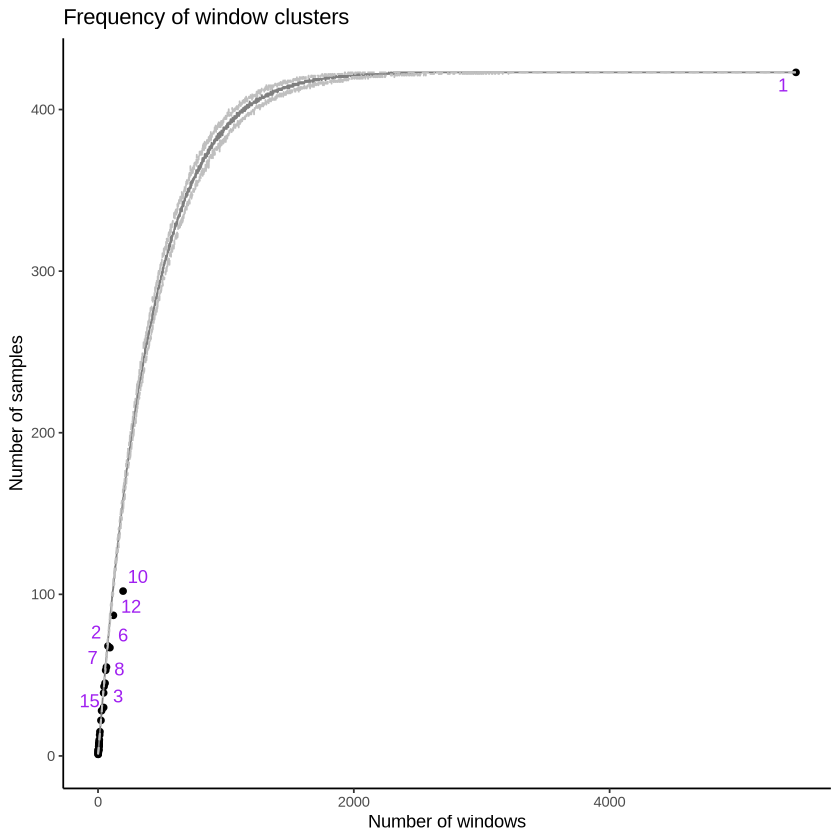

In [142]:
# Plot and save
gp <- ggplot(cluster_stats, aes(y = samples, x = windows)) +
    geom_point() +
    theme_classic() + 
    geom_line(data = expected_samples_per_windows,
               aes(y = X50., x = windows), color = "gray50") + 
     geom_line(data = expected_samples_per_windows,
               aes(y = X90., x = windows), color = "gray75", lty = 2) + 
     geom_line(data = expected_samples_per_windows,
               aes(y = X10., x = windows), color = "gray75", lty = 2) +
    #  geom_text_repel(aes(label = label), color = "gray75") +
     geom_text_repel(aes(label = label_selected), color = "purple") +
     ggtitle("Frequency of window clusters") +
     xlab("Number of windows") + 
     ylab("Number of samples") 
# ggsave("../../figures/fig4/kasumi_cluster_frequency.pdf", gp)
gp

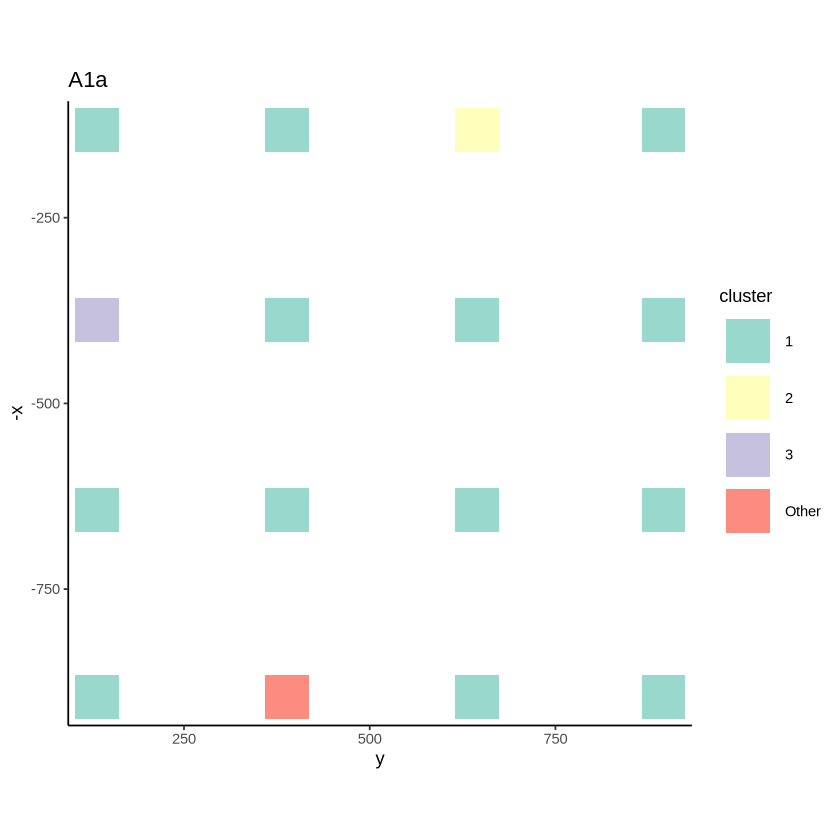

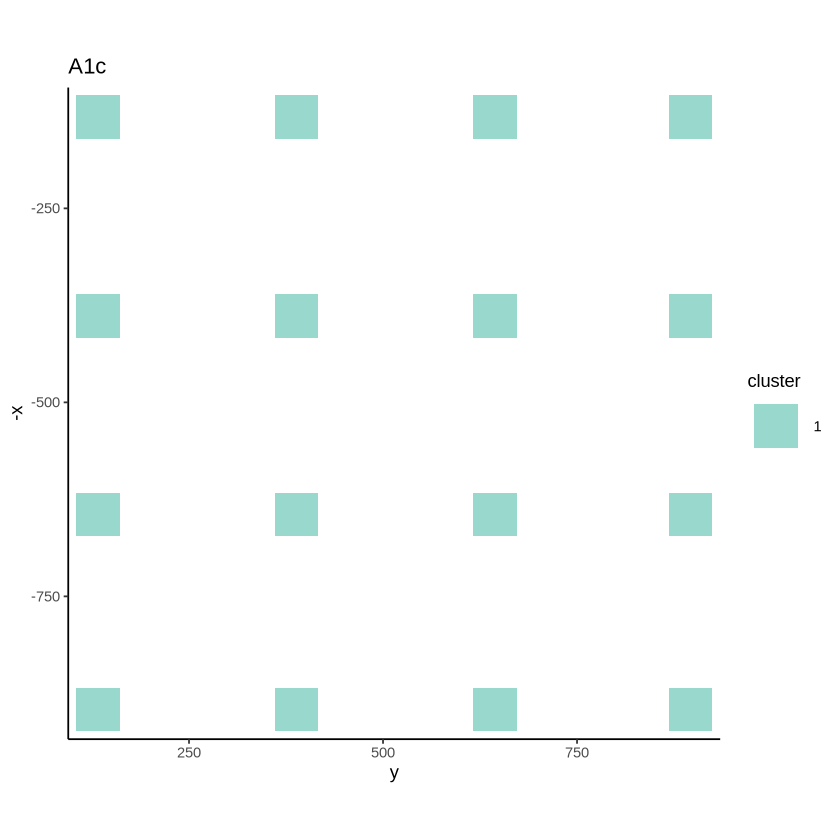

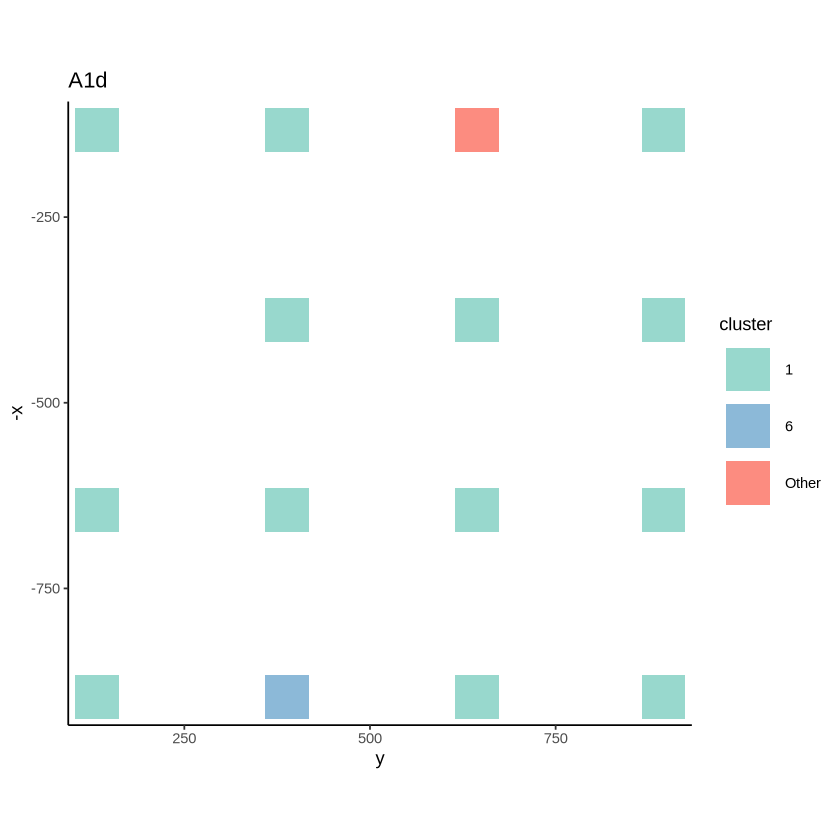

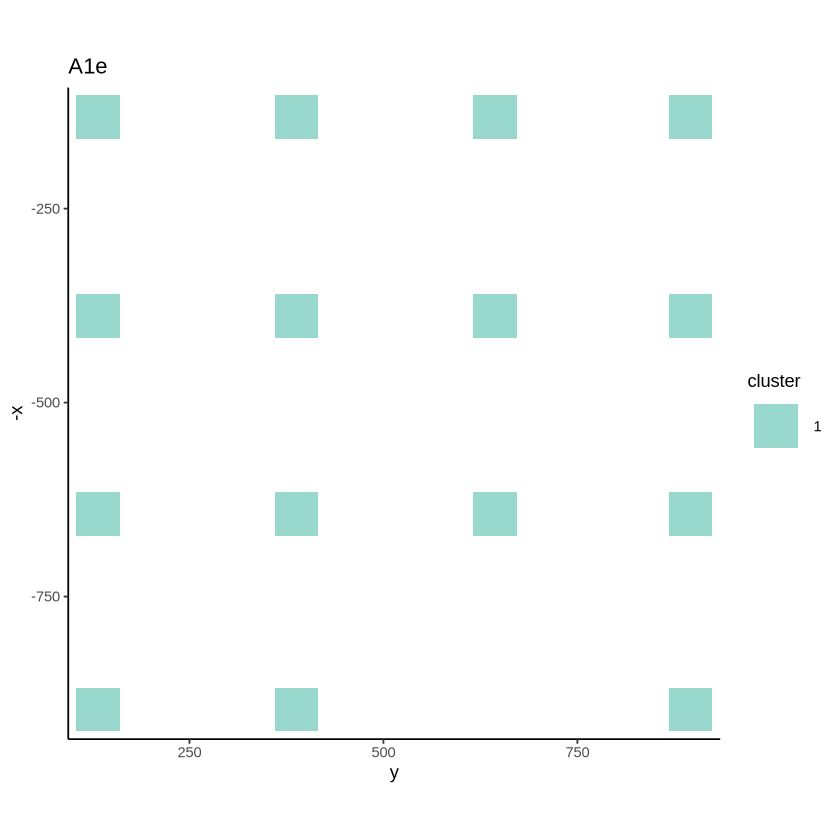

In [222]:
clusters_selected <- cluster_stats$label_selected %>% 
    na.omit %>% 
    as.numeric

# For each row in each tibble, find which column is true (which cluster the window belongs to)
window_cluster_summary <- sm.repr.ext %>% map(
    ~ .x %>%
    select(-id, -x, -y) %>%
    mutate(cluster = names(.)[max.col(.)] %>% str_remove(pattern = "...")) %>% 
    mutate(cluster = ifelse(cluster %in% clusters_selected, cluster, "Other")) %>%
    select(cluster)
)

# Add x and y coordinates from the original tibbles
window_cluster_summary <- map2(window_cluster_summary, sm.repr.ext, 
    ~ cbind(.x, .y %>% select(id, x, y)))

# Get unique values across the "cluster" columns of each tibble of the list
all_clust <- window_cluster_summary %>%
    map(~ .x$cluster) %>%  # Extract the "cluster" column from each tibble
    unlist() %>%           # Combine the lists into a single vector
    unique()               # Get the unique values

# palette <- brewer.pal(12, "Set3")
palette <- c(brewer.pal(12, "Set3"), brewer.pal(6, "Set1"))
# palette <- c(brewer.pal(12, "Set3"), brewer.pal(8, "Set2"), brewer.pal(6, "Set1"))

# Map a unique color to each cluster
cluster_colors <- setNames(palette, all_clust)

# Display the cluster of each window in each sample
# Plot title should be the first element of the "id" column
# Coordinates of each dot are in the "x" and "y" columns
# Color should be which one of the remaining columns has a "true" value
window_cluster_summary[1:4] %>% map(
    ~ ggplot(.x, aes(x = y, y = -x, color = cluster)) +
        geom_point(size = 12, shape = "square", alpha = 0.9) +
        theme_classic() +
        coord_fixed() +
        scale_color_manual(values = cluster_colors) +
        ggtitle(.x$id[1])
    ) %>% walk(print)

### Compare frequency per stage

In [ ]:
# Get first "Stage" per "fov"
stages <- cells %>% 
    group_by(fov) %>%
    summarize(stage = first(Stage))
# Join cluster frequencies with stages
sm.repr.stage <- sm.repr %>%
    left_join(stages, join_by(id == fov))
# Rename columns
sm.repr.stage <- sm.repr.stage %>% 
    rename_with(~ paste0("Cluster", str_remove(.x, "...")), starts_with("..."))

pal_stages <- c(rgb(127,201,127,maxColorValue=255),
                rgb(242,240,247,maxColorValue=255),
                rgb(203,201,226,maxColorValue=255),
                rgb(158,154,201,maxColorValue=255),
                rgb(106,81,163,maxColorValue=255))


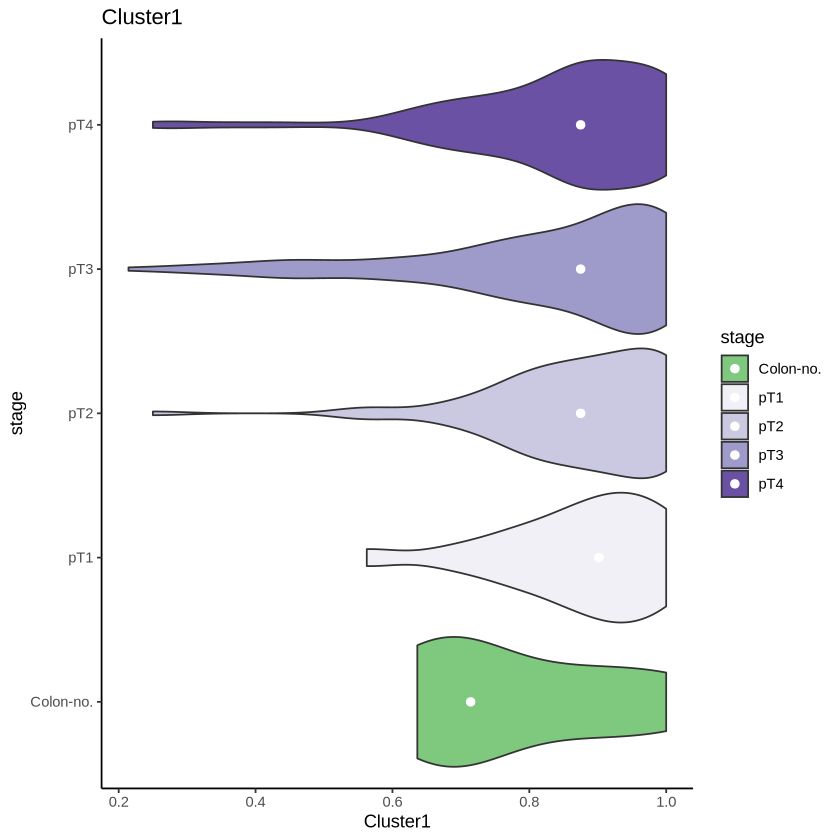

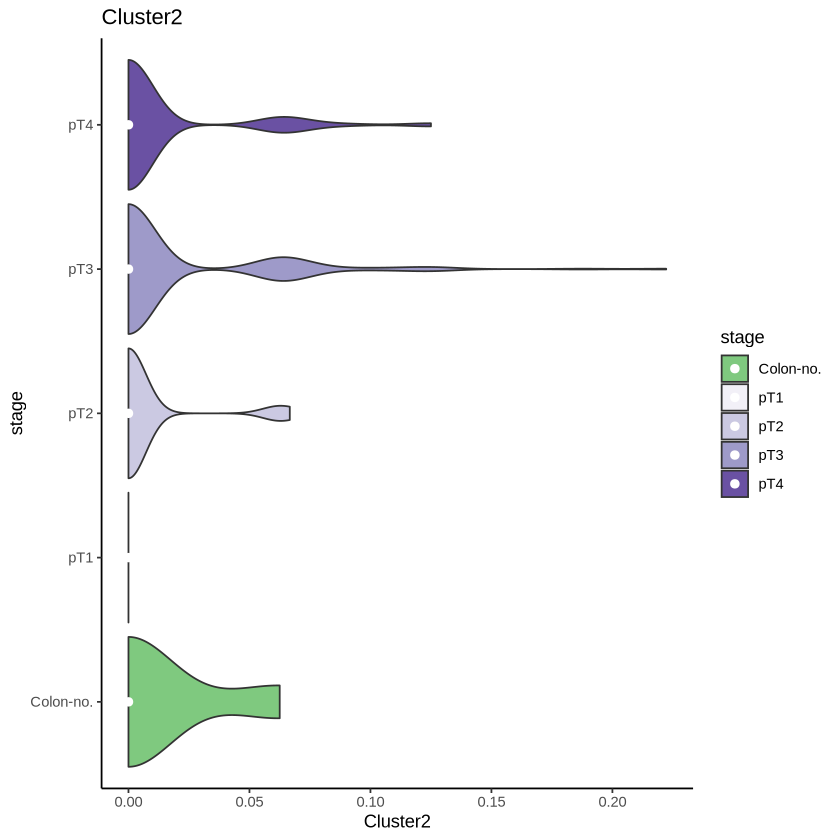

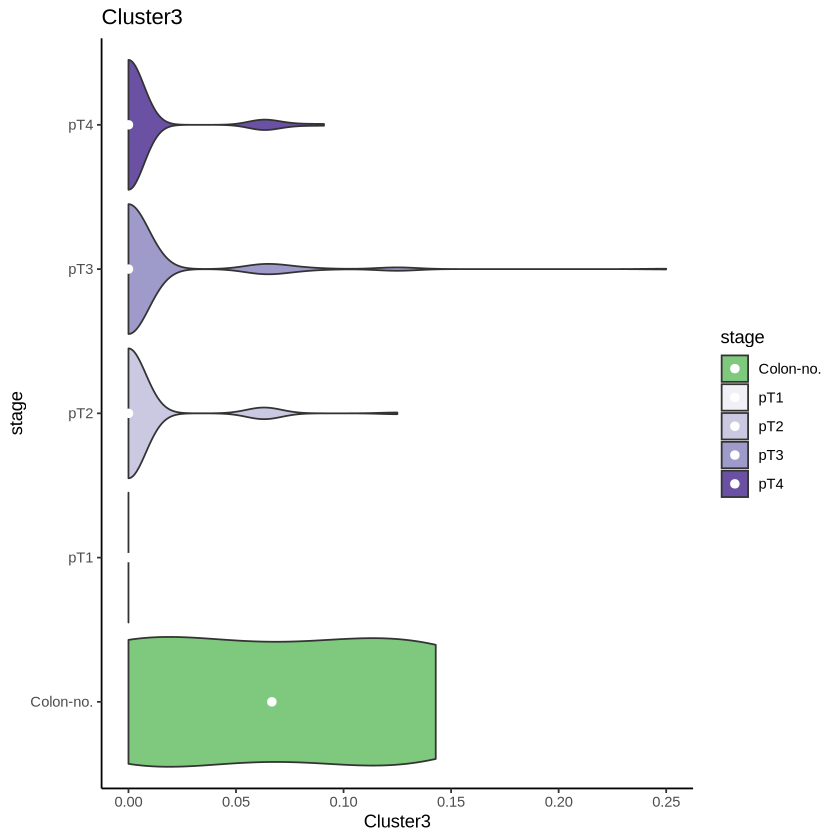

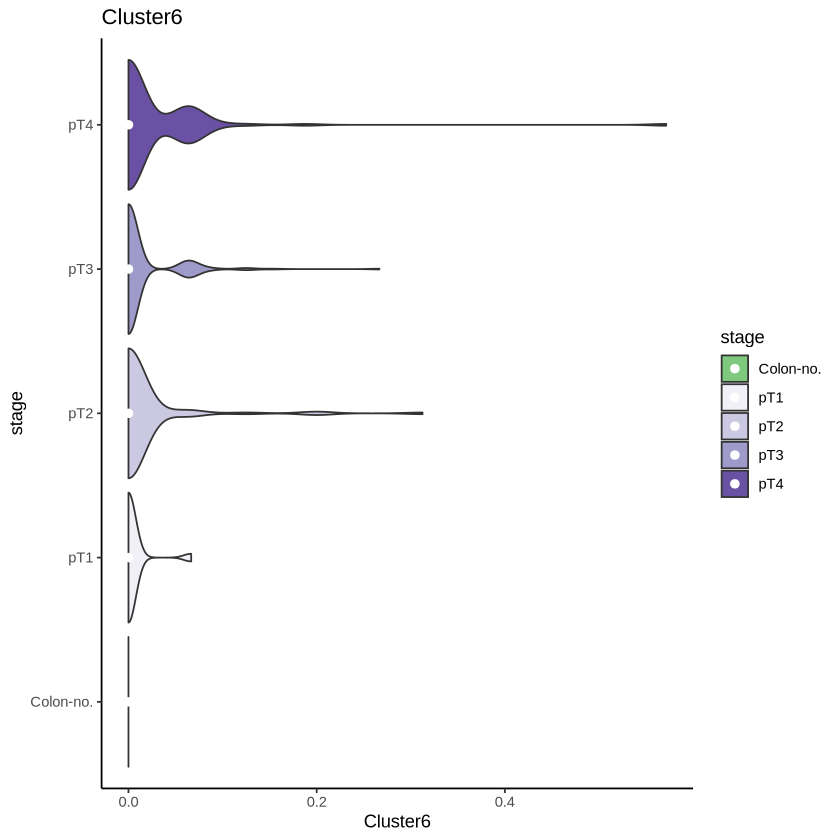

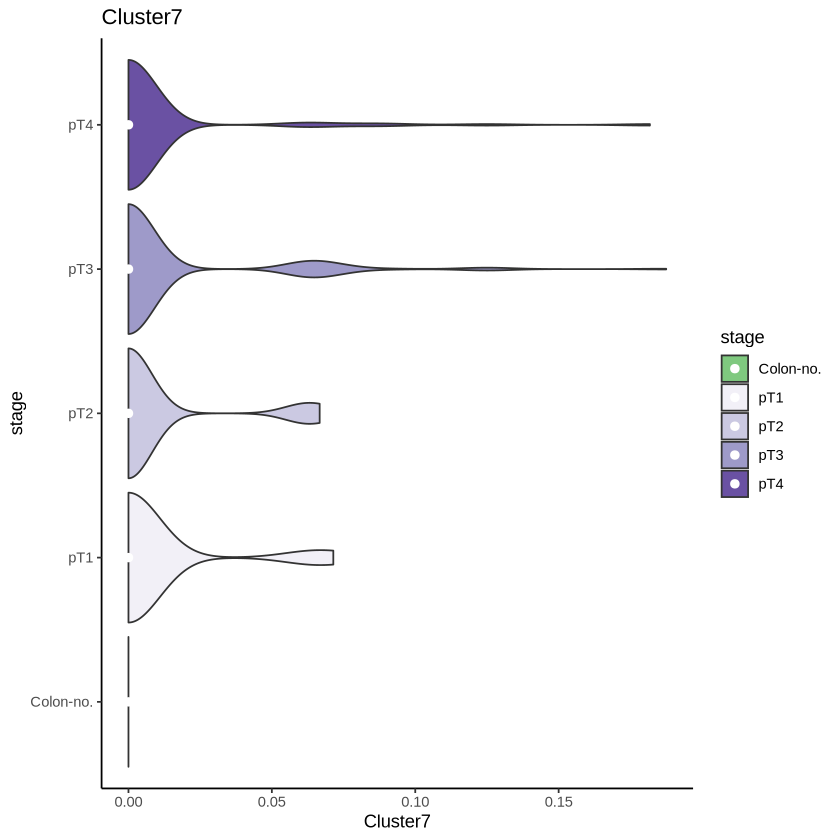

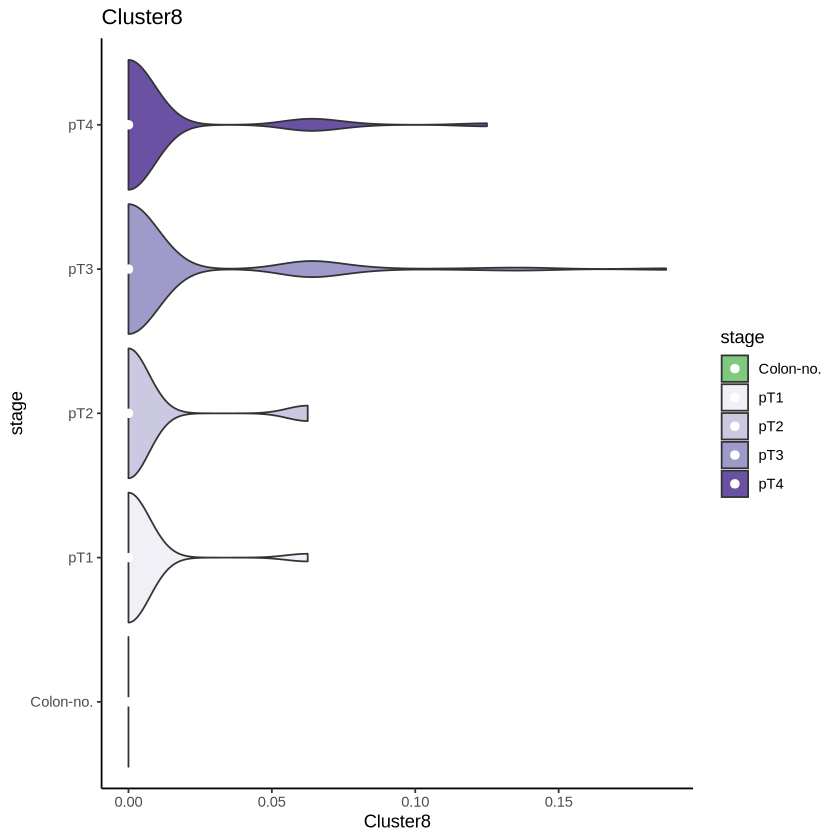

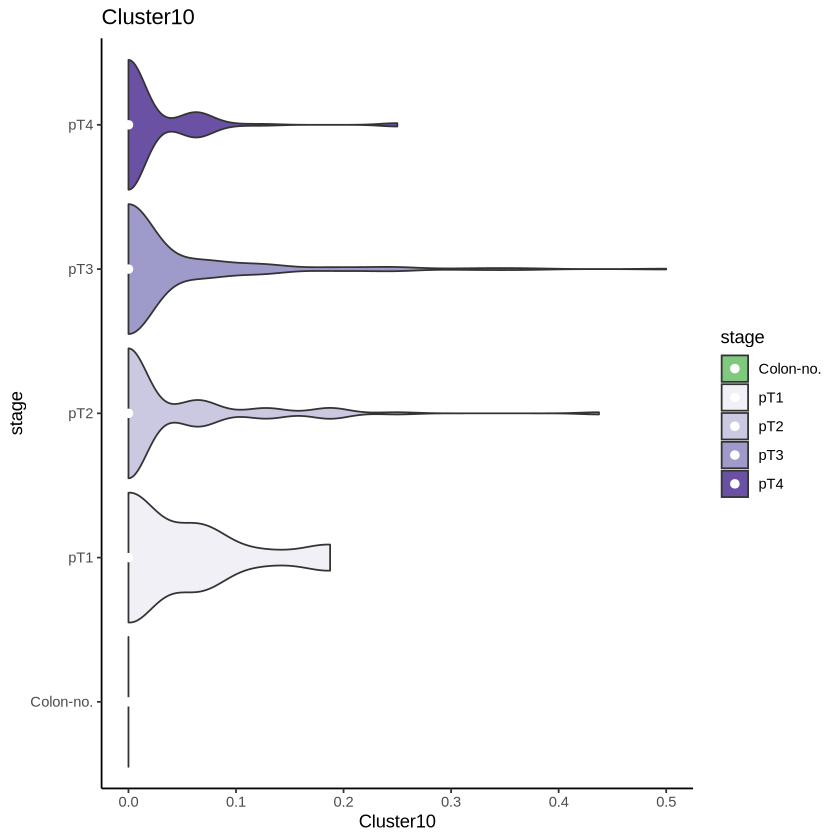

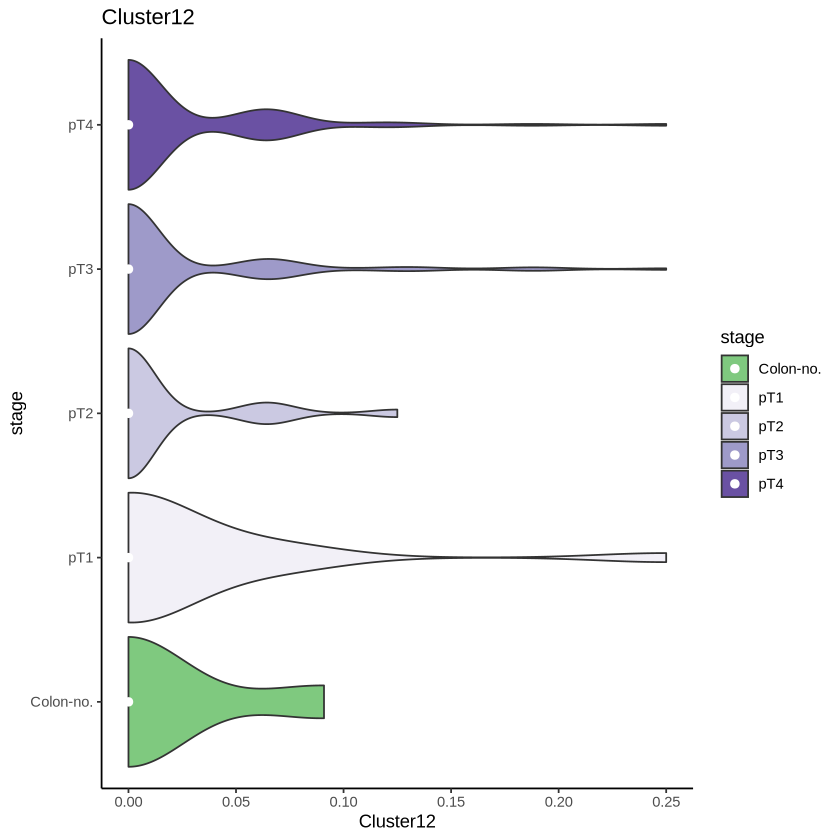

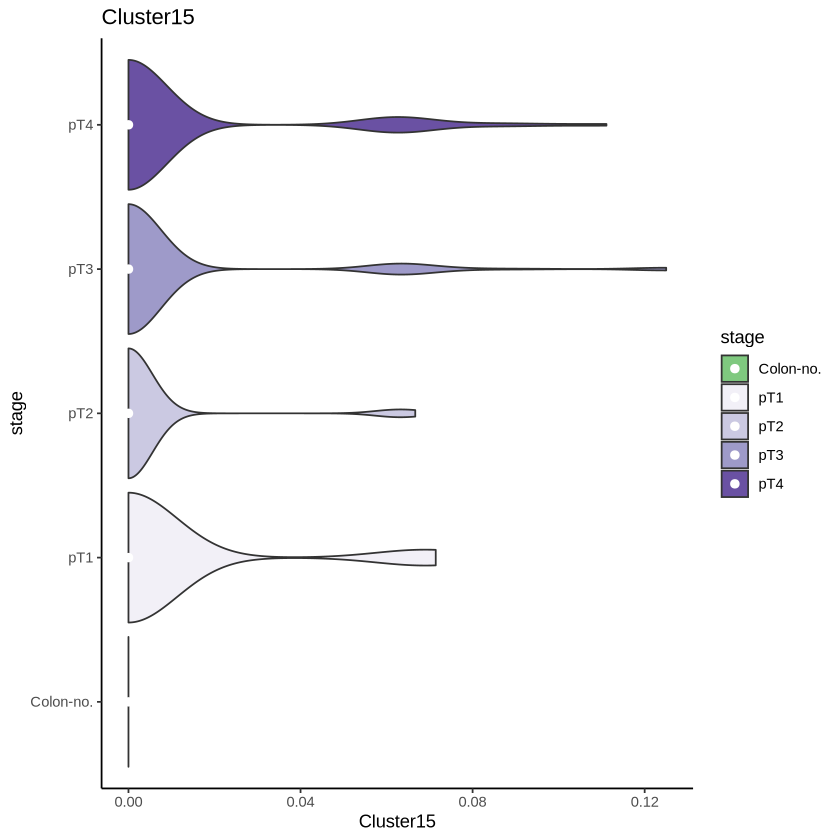

In [221]:
for (cluster_plot in names(sm.repr.stage)[2:10]){
    gp <- (ggplot(sm.repr.stage, aes(y = !!sym(cluster_plot), x = stage, fill = stage))
        + geom_violin(scale="width")
        + theme_classic()
        + coord_flip()
        + stat_summary(fun=median, geom='point', color='white', size=2)
        + scale_fill_manual(values = pal_stages)
        + ggtitle(cluster_plot)
    )
    print(gp)
}